# Twitter sentiment analysis

Dataset from: http://help.sentiment140.com/for-students/ and also https://www.kaggle.com/kazanova/sentiment140 

Code **based on:** https://www.kaggle.com/arunrk7/nlp-beginner-text-classification-using-lstm - please also check this notebook for more comments to what is happening.

**Added:** inference with the trained model, scripts to download data more easily to a Colab, some tricks to shorted the time needed to train the model (results will not be the best, but they can be shown during an online session...).


*PS: there was a paper released with this dataset, check it here [TwitterDistantSupervision09.pdf](https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)*

In [2]:
# download data
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip -q trainingandtestdata.zip

--2021-02-08 22:12:11--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2021-02-08 22:12:11--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  31.4MB/s    in 2.5s    

2021-02-08 22:12:14 (31.4 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [3]:
!ls -luah training.1600000.processed.noemoticon.csv

-rw-r--r-- 1 root root 228M Mar  4  2010 training.1600000.processed.noemoticon.csv


In [ ]:
"""
What is the format of the training data?
The data is a CSV with emoticons removed. Data file format has 6 fields:
0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1 - the id of the tweet (2087)
2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3 - the query (lyx). If there is no query, then this value is NO_QUERY.
4 - the user that tweeted (robotickilldozr)
5 - the text of the tweet (Lyx is cool)
"""

## Environment setup

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

print("Tensorflow Version",tf.__version__)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.4.1


In [5]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

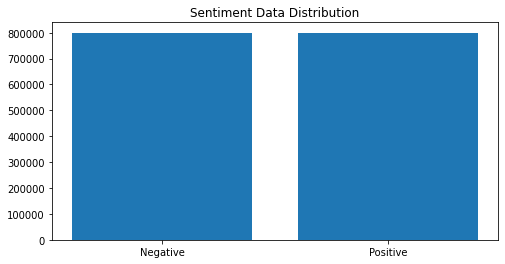

In [8]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")


In [9]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
1362264,Positive,@msmcporkchop and those ice cream trucks are s...
1259164,Positive,I just received a message if I want to contrib...
1423755,Positive,"@lovespellfatale LOL , yeah I was drinking all..."
512773,Negative,is an awesome band. (it's pronounced &quot;co...
994695,Positive,@AveryYaleKamila Just the phrase &quot;heirloo...
1488082,Positive,See...I did make it to church! On time!
1351321,Positive,@SheilafightsEB Thanks for the #FF
1564548,Positive,@dezjwarnae im not guzzling anyone's love at ...
345359,Negative,@deadra PiÃ±ata came back last night. I am an ...
510230,Negative,@HellyJB thats sad rip


## Text cleanup, tokenization, pre-processing

In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [11]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [12]:
# takes some time ...
df.text = df.text.apply(lambda x: preprocess(x))

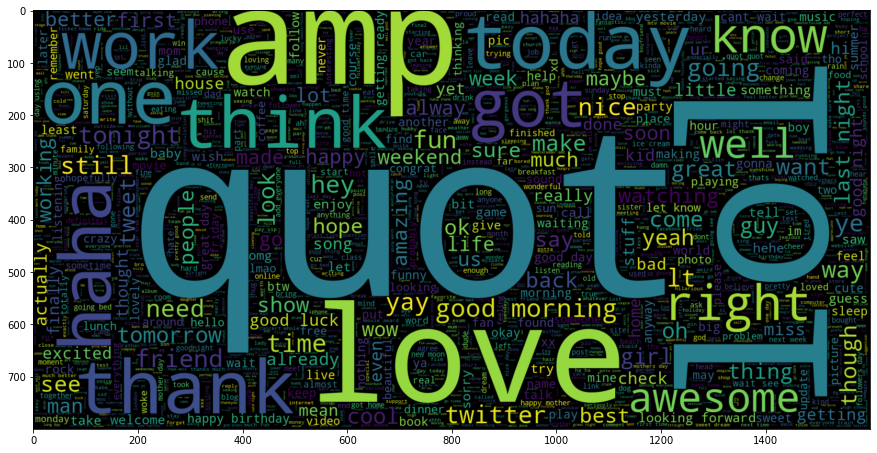

In [13]:
from wordcloud import WordCloud

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

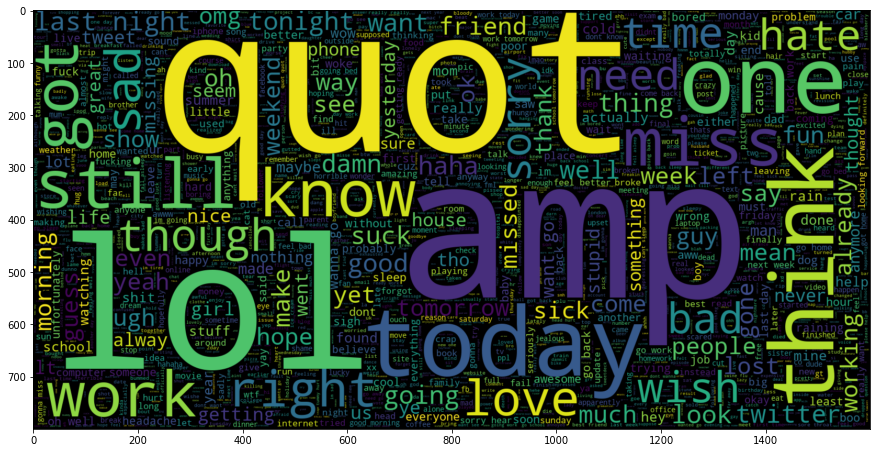

In [14]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [15]:
# ps: we have a full train-test set in the downloaded files from http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
#     but we can also just split the loaded and preprocessed data ....

TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [16]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


In [17]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [18]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)


Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [19]:
# let's see what we have done ...
print(x_train[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   18  133
  220 2319]


In [20]:
# and debug output ...
tokenizer.sequences_to_texts([x_train[1]])

['im trying call impossible']

In [21]:
labels = train_data.sentiment.unique().tolist()

In [22]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [23]:
# which label was it?
print(y_train[1])

[0]


In [ ]:
# GloVe text embedding - fast download

!gdown https://drive.google.com/uc?id=1cPrdK4kMnXDmEh1KQvL39VorE85CglEd
!unzip glove.6B.300d.txt.zip
!gdown https://drive.google.com/uc?id=1tbYUKyZMX-FcmJLz0fU968pztl_XoNrG
!unzip glove.6B.50d.txt.zip
!ls

In [ ]:
# GloVe text embedding - original slower source
# ... pretty slow (822MB) ~ 5+ min
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [107]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
#GLOVE_EMB = '/content/glove.6B.50d.txt'
#EMBEDDING_DIM = 50

LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '/content/best_model.hdf5'

In [108]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [109]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [110]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# will convert data (the first 30 letters from each tweet) into GloVe representation (50 or 300 dimensional vector)

## Sequential LSTM model

In [ ]:
"""
For model architecture, we use

1) Embedding Layer - Generates Embedding Vector for each input sequence.

2) Conv1D Layer - Its using to convolve data into smaller feature vectors.

3) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) Dense - Fully Connected Layers for classification
"""

In [111]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 50)            14528750  
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 30, 50)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 26, 64)            16064     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_21 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0   

In [112]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)


In [113]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

# CPU -> one epoch takes about 20 minutes ...
# CPU -> one epoch takes about 2 minutes ...

Training on GPU...


In [ ]:
# for presentation purposes we might use some speed up hacks ... 
# ... like using only a portion of the dataset

subset =  int( len(x_train) / 8 ) # from 1250
history = model.fit(x_train[:subset], y_train[:subset], batch_size=2*BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

# cca 24-29 sec with 300d vectors
# cca 21 sec with 50d vectors

In [ ]:
#history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
#                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

### Training plots:

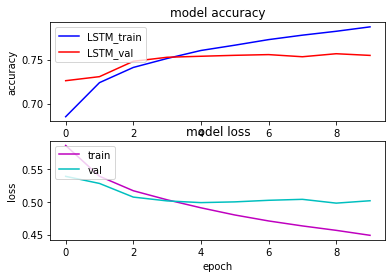

In [89]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')


In [90]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 5s 146ms/step


In [91]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


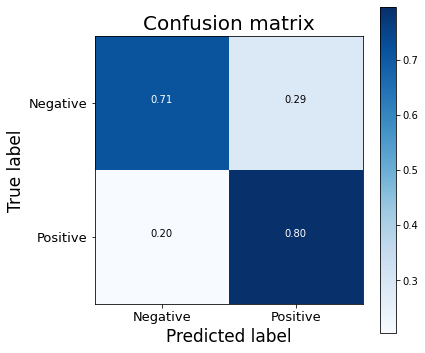

In [92]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()


In [93]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.71      0.75    160542
    Positive       0.73      0.80      0.76    159458

    accuracy                           0.75    320000
   macro avg       0.76      0.75      0.75    320000
weighted avg       0.76      0.75      0.75    320000



### Interacting with the trained model

In [55]:
custom_text = "The universe is a good place"
#custom_text = "The universe is a bad place"

x_custom = pad_sequences(tokenizer.texts_to_sequences([custom_text]),
                        maxlen = MAX_SEQUENCE_LENGTH)

print("^ this gets represented as:", x_custom)

^ this gets represented as: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 2698
     1  305]]


In [56]:
scores_custom = model.predict(x_custom, verbose=1, batch_size=10000)
print("model prediction:", scores_custom)
y_pred_1d_custom = [decode_sentiment(score) for score in scores_custom]
print("decoded:", y_pred_1d_custom)

1/1 [==============================] - 0s 26ms/step
model prediction: [[0.9258636]]
decoded: ['Positive']


## Custom, smaller model ...

In [ ]:
"""
For model architecture, we use

1) Embedding Layer - Generates Embedding Vector for each input sequence.

2) Conv1D Layer - Its using to convolve data into smaller feature vectors.

3) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) Dense - Fully Connected Layers for classification
"""

In [115]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input) # lots of frozen weights ...
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model_ours = tf.keras.Model(sequence_input, outputs)

model_ours.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 50)            14528750  
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 30, 50)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 26, 64)            16064     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0   

In [116]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_ours.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:
EPOCHS = 10

# 1min
#history = model_ours.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
#                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

# 43sec
#history = model_ours.fit(x_train, y_train, batch_size=BATCH_SIZE*2, epochs=EPOCHS,
#                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

# 15 sec ~ with 300d embedding
# 11 sec ~ with 50d embedding
subset = int( len(x_train) / 8 ) # one quarter of the data
history = model_ours.fit(x_train[:subset], y_train[:subset], batch_size=BATCH_SIZE*2, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])


### Training plots:

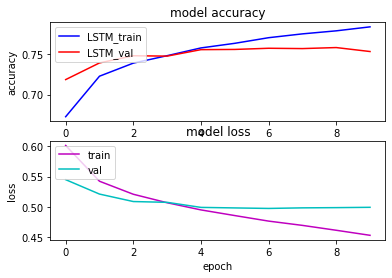

In [97]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')


In [98]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

scores = model_ours.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 4s 121ms/step


In [99]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


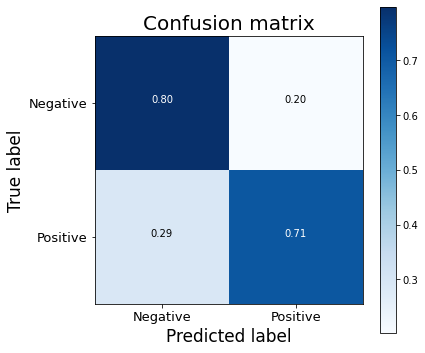

In [100]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [101]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.73      0.80      0.76    160542
    Positive       0.78      0.71      0.74    159458

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



### Interacting with the trained model

In [103]:
custom_text = "The universe is a good place"
#custom_text = "The universe is a bad place"

x_custom = pad_sequences(tokenizer.texts_to_sequences([custom_text]),
                        maxlen = MAX_SEQUENCE_LENGTH)

print("^ this gets represented as:", x_custom)

^ this gets represented as: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 2698
     1  305]]


In [104]:
scores_custom = model_ours.predict(x_custom, verbose=1, batch_size=10000)
print("model prediction:", scores_custom)
y_pred_1d_custom = [decode_sentiment(score) for score in scores_custom]
print("decoded:", y_pred_1d_custom)

1/1 [==============================] - 0s 224ms/step
model prediction: [[0.8245092]]
decoded: ['Positive']
